## Setup


In [8]:
# This should be at 1500 but can be set to a lower number for quick testing
NUM_TRIALS = 50

In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn as skl
import random
from scipy.stats import powerlaw
from sklearn.linear_model import LinearRegression
import statistics
from numpy.random import normal
from scipy.spatial import distance
from tqdm import tqdm, trange
import powerlaw
import warnings
from statistics import median
warnings.filterwarnings("ignore")
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import sys
from contextlib import contextmanager

RANDOM_SEED = 2024
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

df_ref = pd.read_csv('VariationOf_0320_2025.csv')
df_ref = df_ref.dropna()
df_ref.reset_index(inplace=True)

# Helper function that's used later
@contextmanager
def suppress_stdout():
    """Context manager to suppress stdout temporarily"""
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Some global variables

# the current simulated parameter choices
alpha = 7.5
# GD: normal distribution(mean = 7.5, sd=1)
# 500 people 
GD = np.random.normal(loc=7.5, scale=1, size=500)
GD = [min(max(x,5),10) for x in GD]
# kappa: normal distribution(mean = 0.65, sd=0.1)
# 500 people 
kappa = np.random.normal(loc=0.65, scale=0.1, size=500)
kappa = [min(max(x,0.5),0.8) for x in kappa]

In [10]:
# Copied from other file
# function for utility simulation
def sim_u(time,u_0,sigma,beta=0.8):
    eps_list = normal(0, sigma, time)
    u_list = [u_0]
    count = 0
    for t in range(1,time):
        u_temp = u_0
        for i in range(t):
            u_temp += eps_list[i] * beta ** (t-i-1)
        if u_temp <= 0:
            count += 1
        u_list.append(max(0,u_temp))                   # make sure utility is larger than 0
    # bad_percent = count/time
    return u_list


# In[15]:


# function for reward simulation
def updateR(reward, utility, choice, time, lambda_r):
    reward[time] = reward[time-1]
    # repeated_choice = choice[time-1] == choice[time]
    # if repeated_choice:
    product = choice[time]
    reward[time][product] = reward[time-1][product] + lambda_r*(utility[time-1][product]-reward[time-1][product])
    return reward


# In[16]:


# function for doubt stock simulation
def updateD(doubt, utility, reward, choice, time ,lam_d, delta):
    doubt[time] = (1 - lam_d)*doubt[time-1] + lam_d
    a = choice[time]
    doubt[time][a] = (1-lam_d)*doubt[time-1][a] + lam_d*abs((utility[time-1][a]-reward[time-1][a]))
    doubt[time][abs(1-a)] = (1-lam_d)*doubt[time-1][abs(1-a)] + delta
    return doubt


# In[17]:


# function for calculate goal-oriented probability
def calcGDProb(doubt, choice, time, kappa, phi, GD):
    a = choice[time]
    prGD = np.reciprocal(1 + math.exp(-GD*(doubt[time][a] - phi)))
    return prGD


# In[18]:


# function for making choice
def calcChoiceProb(reward, choice, time, product, alpha, num_prod=2):
    summ = 0
    for j in range(0,num_prod):
        summ += math.exp(alpha*reward[time-1][j])
    prChoice = (math.exp(alpha*reward[time-1][product]))/summ
    return prChoice


# In[19]:


# function for running the neural-autopilot simulation (length=1500 trials)
def runSimulation(g,lam,delta, kappa, GD, alpha, trials = NUM_TRIALS, num_products=2):
    sigma = (g-0.018)/1.487
    choice = np.zeros(trials, dtype = int)
    util = np.zeros((trials,num_products))
    u_a = sim_u(trials,1+g,sigma)
    u_b = sim_u(trials,1,sigma)
    for i in range(len(u_a)):
        util[i] = ([u_a[i],u_b[i]])
    reward = np.zeros((trials,num_products))
    doubt = np.zeros((trials, num_products))
    habit_track = np.zeros(trials)
    decisions = [0, 1]
    product_index = [i for i in range(0,num_products)]
    habit = 0        # trial counter for habit mode trials
    gd = 0 

    for time in range(trials):
        if time == 0:
            reward[time] = np.array([1+g,1])
            a = np.argmax(reward[time])
            choice[time] = a
            phi = kappa * delta / lam
            next_prob = calcGDProb(doubt,choice,time, kappa, phi,GD) 
            draw_decision = random.choices(decisions, weights=[next_prob, 1-next_prob], k=1)
            habit_mode = bool(draw_decision[0])
        else:
            if not habit_mode:
                choice1 = calcChoiceProb(reward,choice,time, 0, alpha = alpha)
                choice2 = calcChoiceProb(reward,choice,time, 1, alpha = alpha)
                choices = [choice1, choice2]
                a = random.choices(product_index, weights=choices, k=1)
                choice[time] = a[0]
            else: 
                choice[time] = choice[time-1]
                habit += 1
            reward = updateR(reward, util, choice, time,lam)
            doubt = updateD(doubt, util, reward, choice, time,lam,delta)
            next_prob = calcGDProb(doubt,choice,time, kappa, phi,GD) 
            draw_decision = random.choices(decisions, weights=[next_prob, 1-next_prob], k=1)
            habit_mode = bool(draw_decision[0])
        habit_track[time] = habit_mode
        eta = habit/trials
    choice_percent = sum(choice)/len(choice)
    
    return choice, util, reward, doubt, habit_track, (choice_percent, habit, gd, eta)


# In[20]:


# function for fitting the moments (slope, r2, %of1) from simulated data
def sim_and_fit(param_space):
    choices, habit_ones, habit_zeros, habit_time_proportions = [], [], [], []
    for gap,lam,delta,kappa,GD,alpha in param_space:
        choice, util, reward, doubt, habit_track, stats = runSimulation(gap,lam,delta,kappa,GD,alpha)
        choices+=list(choice)
        
        habit_time_proportion = sum(habit_track) / len(habit_track)

        habit_time_proportions.append(habit_time_proportion)

        habit_count = []
        for i in range(len(choice)):
            if habit_track[i] == 1:
                habit_count.append(choice[i])
        if len(habit_count) > 0:
            habit_in_one = sum(habit_count)/len(habit_count)
            habit_in_zero = 1 - habit_in_one
        else:
            habit_in_one = 0  # or some other default value
            habit_in_zero = 0  # or some other default value
        habit_ones.append(habit_in_one)
        habit_zeros.append(habit_in_zero)

    # Simple average
    habit_in_one = sum(habit_ones) / len(habit_ones)
    habit_in_zero = sum(habit_zeros) / len(habit_zeros)
    avg_habit_time = sum(habit_time_proportions) / len(habit_time_proportions)

    percent_of_one = sum(choices)/len(choices)
    collapse_choice = [float(i) for i in np.array(choices)]
    collapse_choice = [float('nan') if x==1 else x for x in collapse_choice]
    gamma = []
    for i in range(0,len(collapse_choice)):
        if round(collapse_choice[i],1) == 0.0:
            gamma.append(i)
    tau_bar = [gamma[i] - gamma[i-1] for i in range(1,len(gamma))]
    dfTL = pd.DataFrame(tau_bar, columns=['TL'])
    dfTL['counts'] = gamma[0:len(gamma)-1]

    # calculate the powerlaw x-min
    results = powerlaw.Fit(tau_bar)
    x_min = results.xmin
    # fitted linear regression with only data larger than x-min
    time_lags = dfTL[dfTL['TL']>x_min].groupby(dfTL[dfTL['TL']>x_min]['TL']).count()
    tau_total = len(time_lags)
    log_time_lags = np.log(time_lags.index)
    log_frequency = np.log(time_lags.counts/dfTL[dfTL['TL']>x_min].shape[0])
    prob_weight = time_lags.counts

    if prob_weight.all() != 1.0:
        prob_weight = np.log(prob_weight)

    X = np.array(log_time_lags)
    X = X.reshape(len(X),1)
    y = np.array(log_frequency)
    y = y.reshape(len(y),1)

    sample_weight = prob_weight

    if tau_total >= 3:
        regWLS = LinearRegression()
        regWLS.fit(X, y, sample_weight)
        slope_WLS = regWLS.coef_[0][0]
        r2_WLS = regWLS.score(X, y, sample_weight)
    else:
        slope_WLS = np.nan
        r2_WLS = np.nan

    return percent_of_one, slope_WLS, r2_WLS, habit_in_one, habit_in_zero, avg_habit_time
    

In [11]:
data = df_ref[['slope_WLS_mean', 'R2_WLS_mean', 'pO1_mean']]
# scaler = StandardScaler() # standardize
scaler = MinMaxScaler() # normalize
data_scaled = scaler.fit_transform(data)

kNN1 = NearestNeighbors(n_neighbors=1)
kNN1.fit(data_scaled)

def find_closest_parameters(slope_train, r2_train, percent_train, suppress_output=False):
    """
    NOTE: THIS IS ENTIRELY COPIED FROM THE OTHER FILE
    Finds the closest matching parameters (g, lam, delta) based on input and reference data.
    
    Args:
        slope_train: Slope value that was fitted based on simulation
        r2_train: R-squared value that was fitted based on simulation
        percent_train: Percentage value that was fitted based on simulation
        
    Returns:
        tuple: (g, lam, delta) - The closest matching parameters from reference data
    """
    

    # a, b = kNN1.kneighbors([[slope_train, r2_train, percent_train]])
    train_temp = scaler.transform([[slope_train, r2_train, percent_train]])
    a, b = kNN1.kneighbors(train_temp)
    
    # slope_hat, r2_hat = df_ref.loc[b[0][0]]['slope_WLS_mean'], df_ref.loc[b[0][0]]['R2_WLS_mean']
    # percent_hat = df_ref.loc[b[0][0]]['pO1_mean']
    g, lam, delta = df_ref.loc[b[0][0]]['g'], df_ref.loc[b[0][0]]['lam'], df_ref.loc[b[0][0]]['delta']
    # gd, kappa = df_ref.loc[b[0][0]]['GD'], df_ref.loc[b[0][0]]['kappa']
    # alpha = df_ref.loc[b[0][0]]['alpha']

    return g, lam, delta

def estimate_parameters(vector_set, suppress_output=False): # vector_set is a list of 5 elements defined as in the slides
    """
    This function takes a set of behavioral parameters and runs a simulation to analyze 
    habit-forming patterns. It prints various metrics including the initial parameters
    and simulation results, then finds the closest matching parameters from reference data,
    essentially estimating the original parameters from the simulation (if my understanding is correct)

    This is completing the first part of the task assigned to me (Matthew Casertano) on 4/16/25

    Args:
        vector_set (list): A list of 5 behavioral parameters:
            - G: Initial utility difference between actions (gym vs no-gym)
            - lambda: Learning rate for utility/doubt updates
            - delta: Doubt growth factor from lack of feedback
            - GD: Stochasticity degree of decision-making
            - kappa: Habit-forming sensitivity
        suppress_output (bool): Whether to suppress output

    Returns:
        Euclidean distance between the initial parameters and the estimated parameters (the function also prints a lot)
    """
    (gt_G, gt_lam, gt_delta, _, _) = vector_set # we don't need GD and kappa

    param_space = []
    for i in range(500):
        param_space.append([gt_G,gt_lam,gt_delta,kappa[i],GD[i],alpha])

    # Run simulation
    if not suppress_output:
        percent_of_one, slope_WLS, r2_WLS, habit_in_one, habit_in_zero, avg_habit_time = sim_and_fit(param_space)
        
    else:
        with suppress_stdout():
            percent_of_one, slope_WLS, r2_WLS, habit_in_one, habit_in_zero, avg_habit_time = sim_and_fit(param_space)

    
    if np.isnan(slope_WLS) or np.isnan(r2_WLS):
        # If we have NaN values, return a placeholder distance of 1
        # print(f"NaN values encountered for parameters: G={gt_G}, lambda={gt_lam}, delta={gt_delta}")
        return 1.0, (gt_G, gt_lam, gt_delta)  # Return the original parameters as the "fitted" ones

    fitted_g, fitted_lam, fitted_delta = find_closest_parameters(slope_WLS, r2_WLS, percent_of_one)

    if not suppress_output:
        # Print initial values, final estimates, and differences
        print("Parameter    Initial   Final   Difference")
        print("-----------------------------------------")
        print(f"G:            {gt_G:.3f}    {fitted_g:.3f}    {gt_G-fitted_g:.3f}")
        print(f"Lambda:       {gt_lam:.3f}    {fitted_lam:.3f}    {gt_lam-fitted_lam:.3f}")
        print(f"Delta:        {gt_delta:.3f}    {fitted_delta:.3f}    {gt_delta-fitted_delta:.3f}")

    euclidean_distance = np.sqrt((gt_G - fitted_g)**2 + (gt_lam - fitted_lam)**2 + (gt_delta - fitted_delta)**2)
    return euclidean_distance, (fitted_g, fitted_lam, fitted_delta)

## Task A

#### Ground truth recovery for some empirical parameter sets


In [12]:
# Run Part A of task assigned on 4/16/25

# Variables

gym = [0.25,0.275,0.126,7.5,0.65]
moment = [0.25,0.175,0.126,7.5,0.65]
weibo = [0.35,0.2,0.155,7.5,0.65]
zearn = [0.25,0.175,0.155,7.5,0.65]

print("Part A")
print("Gym")
estimate_parameters(gym)
print("\nMoment")
estimate_parameters(moment)
print("\nWeibo")
estimate_parameters(weibo)
print("\nZearn")
estimate_parameters(zearn)


Part A
Gym
Calculating best minimal value for power law fit
Parameter    Initial   Final   Difference
-----------------------------------------
G:            0.250    0.262    -0.012
Lambda:       0.275    0.300    -0.025
Delta:        0.126    0.126    0.000

Moment
Calculating best minimal value for power law fit
Parameter    Initial   Final   Difference
-----------------------------------------
G:            0.250    0.275    -0.025
Lambda:       0.175    0.150    0.025
Delta:        0.126    0.126    0.000

Weibo
Calculating best minimal value for power law fit
Parameter    Initial   Final   Difference
-----------------------------------------
G:            0.350    0.250    0.100
Lambda:       0.200    0.150    0.050
Delta:        0.155    0.155    0.000

Zearn
Calculating best minimal value for power law fit
Parameter    Initial   Final   Difference
-----------------------------------------
G:            0.250    0.300    -0.050
Lambda:       0.175    0.100    0.075
Delta:       

(np.float64(0.0946889645101265),
 (np.float64(0.3), np.float64(0.1), np.float64(0.126)))

## Task B

#### Simulation run to test the ground truth recovery

#### After this is run, the file 'analyze.ipynb' can be run which will give further visualizations on the output


In [13]:
# Simulation run for Part B of task assigned on 4/16/25

# Create parameter ranges based on reference data
# Get unique values for each parameter
g_range = sorted(df_ref['g'].unique())
lambda_range = sorted(df_ref['lam'].unique())
delta_range = sorted(df_ref['delta'].unique())

# Calculate maximum possible distance in parameter space
g_max, g_min = max(g_range), min(g_range)
lambda_max, lambda_min = max(lambda_range), min(lambda_range)
delta_max, delta_min = max(delta_range), min(delta_range)

max_distance = np.sqrt((g_max - g_min)**2 + 
                      (lambda_max - lambda_min)**2 + 
                      (delta_max - delta_min)**2)

print(f"Parameter ranges:")
print(f"g: {g_min:.3f} to {g_max:.3f}")
print(f"λ: {lambda_min:.3f} to {lambda_max:.3f}")
print(f"δ: {delta_min:.3f} to {delta_max:.3f}")
print(f"Maximum possible distance: {max_distance:.3f}")

# Initialize or load existing results
results_file = 'parameter_space_results.csv'
if os.path.exists(results_file) and os.path.getsize(results_file) > 0:
    results_df = pd.read_csv(results_file)
    completed_combos = set(zip(results_df['gt_g'], results_df['gt_lambda'], results_df['gt_delta']))
else:
    results_df = pd.DataFrame(columns=['gt_g', 'gt_lambda', 'gt_delta', 'distance', 'fitted_g', 'fitted_lambda', 'fitted_delta'])
    completed_combos = set()

# Calculate distances for each parameter combination
total_iterations = len(g_range) * len(lambda_range) * len(delta_range)
completed_iterations = len(completed_combos)
remaining_iterations = total_iterations - completed_iterations

# Iterate over all parameter combinations as the ground truth parameters
with tqdm(total=remaining_iterations, desc="Calculating distances") as pbar:
    for gt_g in g_range:
        for gt_lambda in lambda_range:
            for gt_delta in delta_range:
                # Skip if this combination has already been processed
                if (gt_g, gt_lambda, gt_delta) in completed_combos:
                    continue
                    
                # Create vector_set with dummy values for GD and kappa (they're not used)
                vector_set = [gt_g, gt_lambda, gt_delta, 7.5, 0.65]
                distance, (fitted_g, fitted_lambda, fitted_delta) = estimate_parameters(vector_set, suppress_output=True)
                
                # Create new row and append to DataFrame
                new_row = pd.DataFrame({
                    'gt_g': [gt_g],
                    'gt_lambda': [gt_lambda],
                    'gt_delta': [gt_delta],
                    'distance': [distance],
                    'fitted_g': [fitted_g],
                    'fitted_lambda': [fitted_lambda],
                    'fitted_delta': [fitted_delta]
                    })
                results_df = pd.concat([results_df, new_row], ignore_index=True)
                
                # Save after each iteration
                results_df.to_csv(results_file, index=False)
                completed_combos.add((gt_g, gt_lambda, gt_delta))
                
                pbar.update(1)

print(f"All results saved to {results_file}")

Parameter ranges:
g: 0.250 to 0.300
λ: 0.100 to 0.300
δ: 0.068 to 0.300
Maximum possible distance: 0.310


Calculating distances: 0it [00:00, ?it/s]

All results saved to parameter_space_results.csv


# Task C

#### - Re-run to understand simulations near NaN (= no available number not enough different IAIs to estimate on)
#### - Run delta, lambda from 0.2
#### - Grab B, R^2, pct1 from across this range
#### - Particularly highlight what they were for the NaN values specifically

Running simulations: 100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


Results from high λ/δ region:
    lambda  delta         B        R2     pct1
0     0.10   0.20       NaN       NaN  0.00004
1     0.10   0.22       NaN       NaN  0.00004
2     0.10   0.24       NaN       NaN  0.00000
3     0.10   0.26       NaN       NaN  0.00000
4     0.10   0.28       NaN       NaN  0.00000
5     0.10   0.30       NaN       NaN  0.00000
6     0.12   0.20 -0.554288  0.574137  0.00240
7     0.12   0.22       NaN       NaN  0.00020
8     0.12   0.24       NaN       NaN  0.00000
9     0.12   0.26       NaN       NaN  0.00004
10    0.12   0.28       NaN       NaN  0.00012
11    0.12   0.30       NaN       NaN  0.00004
12    0.14   0.20 -1.349400  0.727296  0.00296
13    0.14   0.22 -0.924844  0.996148  0.00152
14    0.14   0.24 -0.557413  0.658441  0.00188
15    0.14   0.26 -1.109677  0.879399  0.00028
16    0.14   0.28       NaN       NaN  0.00036
17    0.14   0.30       NaN       NaN  0.00004
18    0.16   0.20 -1.228139  0.886323  0.01744
19    0.16   0.22 -0.950042  

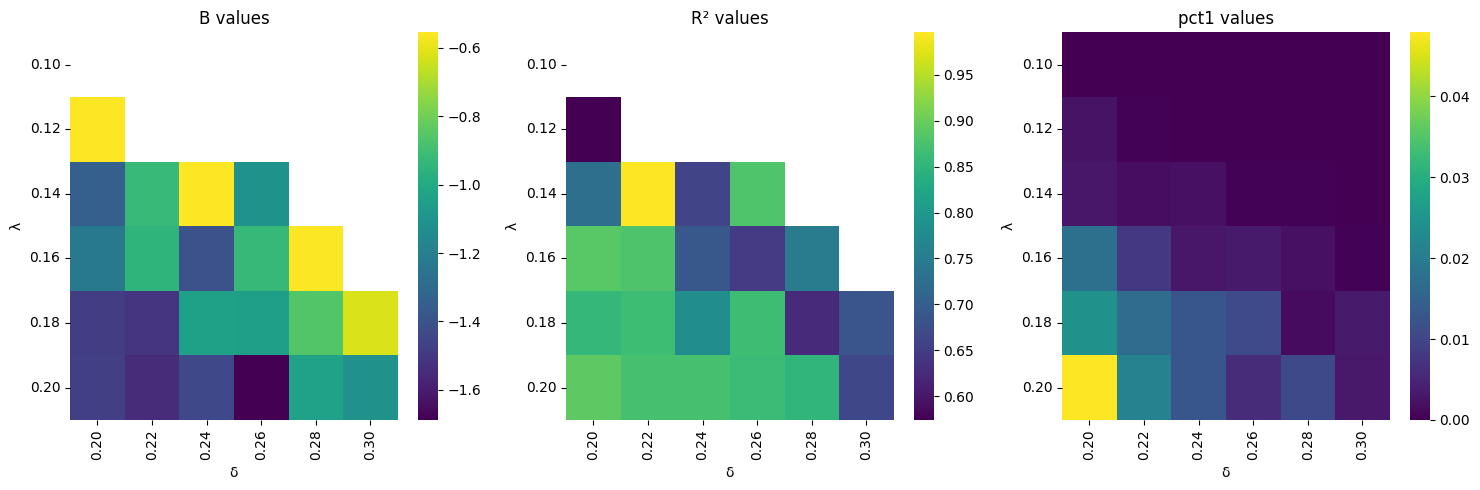

In [14]:
# Create parameter ranges for high lambda/delta region
lambda_range = np.arange(0.1, 0.21, 0.02)  # 0.1 to 0.2 with 0.02 spacing
delta_range = np.arange(0.2, 0.31, 0.02)   # 0.2 to 0.4 with 0.02 spacing
g = 0.25  # Fixed g value

# Initialize results storage
results = []

# Calculate total iterations
total_iterations = len(lambda_range) * len(delta_range)


# Run simulations with progress bar
with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    for lam in lambda_range:
        for delta in delta_range:
            # Run simulation and get metrics
            param_space = []
            for i in range(500):
                param_space.append([g, lam, delta, kappa[i], GD[i], alpha])
            
            with suppress_stdout():
                pct1, B, R2, habit_in_one, habit_in_zero, avg_habit_time = sim_and_fit(param_space)
            
            # Store results
            results.append({
                'lambda': lam,
                'delta': delta,
                'B': B,
                'R2': R2,
                'pct1': pct1
            })
            
            pbar.update(1)

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\nResults from high λ/δ region:")
print(results_df)

# Calculate and display averages
print("\nAverage metrics:")
print(f"B: {results_df['B'].mean():.3f}")
print(f"R²: {results_df['R2'].mean():.3f}") 
print(f"pct1: {results_df['pct1'].mean():.3f}")

# Create heatmaps for each metric
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Reshape data for heatmaps
lambda_vals = sorted(results_df['lambda'].unique())
delta_vals = sorted(results_df['delta'].unique())
B_matrix = results_df.pivot(index='lambda', columns='delta', values='B')
R2_matrix = results_df.pivot(index='lambda', columns='delta', values='R2')
pct1_matrix = results_df.pivot(index='lambda', columns='delta', values='pct1')

# Plot heatmaps
sns.heatmap(B_matrix, ax=ax1, cmap='viridis')
ax1.set_title('B values')
ax1.set_xlabel('δ')
ax1.set_ylabel('λ')
ax1.set_xticklabels([f'{x:.2f}' for x in delta_vals])
ax1.set_yticklabels([f'{x:.2f}' for x in lambda_vals])

sns.heatmap(R2_matrix, ax=ax2, cmap='viridis')
ax2.set_title('R² values')
ax2.set_xlabel('δ')
ax2.set_ylabel('λ')
ax2.set_xticklabels([f'{x:.2f}' for x in delta_vals])
ax2.set_yticklabels([f'{x:.2f}' for x in lambda_vals])

sns.heatmap(pct1_matrix, ax=ax3, cmap='viridis')
ax3.set_title('pct1 values')
ax3.set_xlabel('δ')
ax3.set_ylabel('λ')
ax3.set_xticklabels([f'{x:.2f}' for x in delta_vals])
ax3.set_yticklabels([f'{x:.2f}' for x in lambda_vals])

plt.tight_layout()
plt.show()


# Task D

#### Analyze the proportion of time spent in habit mode for the empirical parameter sets

In [15]:
# the current simulated parameter choices
alpha = 7.5
# GD: normal distribution(mean = 7.5, sd=1)
# 500 people 
GD = np.random.normal(loc=7.5, scale=1, size=500)
GD = [min(max(x,5),10) for x in GD]
# kappa: normal distribution(mean = 0.65, sd=0.1)
# 500 people 
kappa = np.random.normal(loc=0.65, scale=0.1, size=500)
kappa = [min(max(x,0.5),0.8) for x in kappa]

def analyze_habit_time(param_set, suppress_output=True):
    """
    Analyzes the time spent in habit mode for a given parameter set.
    
    Args:
        param_set (list): A list containing [g, lambda, delta, GD, kappa] parameters
        num_simulations (int): Number of simulations to run (default 500)
        suppress_output (bool): Whether to suppress simulation output (default True)
        
    Returns:
        dict: Dictionary containing:
            - avg_habit_time: Average proportion of time spent in habit mode
            - habit_in_one: Proportion of habit trials spent choosing option 1
            - habit_in_zero: Proportion of habit trials spent choosing option 0
            - total_habit_trials: Total number of trials in habit mode
            - percent_habit: Percentage of total trials spent in habit mode
    """
    (gt_G, gt_lam, gt_delta, _, _) = param_set # we don't need GD and kappa

    param_space = []
    for i in range(500):
        param_space.append([gt_G,gt_lam,gt_delta,kappa[i],GD[i],alpha])

    # Run simulation
    if not suppress_output:
        percent_of_one, slope_WLS, r2_WLS, habit_in_one, habit_in_zero, avg_habit_time = sim_and_fit(param_space)
    else:
        with suppress_stdout():
            percent_of_one, slope_WLS, r2_WLS, habit_in_one, habit_in_zero, avg_habit_time = sim_and_fit(param_space)


    return {
        'avg_habit_time': avg_habit_time,
        'habit_in_one': habit_in_one,
        'habit_in_zero': habit_in_zero,
        'percent_of_one': percent_of_one,
        'slope': slope_WLS,
        'r2': r2_WLS
    }

# Example usage:
# gym_params = [0.25, 0.275, 0.126, 7.5, 0.65]
# results = analyze_habit_time(gym_params)
# print(f"Time spent in habit mode: {results['percent_habit']:.2f}%")
# print(f"Proportion of habit trials choosing 1: {results['habit_in_one']:.2f}")
# print(f"Proportion of habit trials choosing 0: {results['habit_in_zero']:.2f}")

# Variables

gym = [0.25,0.275,0.126,7.5,0.65]
moment = [0.25,0.175,0.126,7.5,0.65]
weibo = [0.35,0.2,0.155,7.5,0.65]
zearn = [0.25,0.175,0.155,7.5,0.65]

print("Part A")
print("Gym")
results_gym = analyze_habit_time(gym)
print(f"Proportion of time spent in habit mode: {results_gym['avg_habit_time']:.2f}")
print(f"Proportion of habit trials choosing 1: {results_gym['habit_in_one']:.2f}")
print(f"Proportion of habit trials choosing 0: {results_gym['habit_in_zero']:.2f}")

print("\nMoment")
results_moment = analyze_habit_time(moment)
print(f"Proportion of time spent in habit mode: {results_moment['avg_habit_time']:.2f}")
print(f"Proportion of habit trials choosing 1: {results_moment['habit_in_one']:.2f}")
print(f"Proportion of habit trials choosing 0: {results_moment['habit_in_zero']:.2f}")

print("\nWeibo") 
results_weibo = analyze_habit_time(weibo)
print(f"Proportion of time spent in habit mode: {results_weibo['avg_habit_time']:.2f}")
print(f"Proportion of habit trials choosing 1: {results_weibo['habit_in_one']:.2f}")
print(f"Proportion of habit trials choosing 0: {results_weibo['habit_in_zero']:.2f}")

print("\nZearn")
results_zearn = analyze_habit_time(zearn)
print(f"Proportion of time spent in habit mode: {results_zearn['avg_habit_time']:.2f}")
print(f"Proportion of habit trials choosing 1: {results_zearn['habit_in_one']:.2f}")
print(f"Proportion of habit trials choosing 0: {results_zearn['habit_in_zero']:.2f}")

Part A
Gym
Proportion of time spent in habit mode: 0.72
Proportion of habit trials choosing 1: 0.14
Proportion of habit trials choosing 0: 0.86

Moment
Proportion of time spent in habit mode: 0.88
Proportion of habit trials choosing 1: 0.06
Proportion of habit trials choosing 0: 0.94

Weibo
Proportion of time spent in habit mode: 0.86
Proportion of habit trials choosing 1: 0.08
Proportion of habit trials choosing 0: 0.92

Zearn
Proportion of time spent in habit mode: 0.94
Proportion of habit trials choosing 1: 0.03
Proportion of habit trials choosing 0: 0.97
